<a href="https://colab.research.google.com/github/nanopiero/fusion_2d_od/blob/main/notebooks/build_fusion_2d_of_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports des bibliothèques utiles
# pour l'IA
import torch
# pour les maths
import numpy as np
# pour afficher des images et des courbes
import matplotlib.pyplot as plt

In [2]:
! git clone https://github.com/nanopiero/fusion_2d_od.git

Cloning into 'fusion_2d_od'...
remote: Enumerating objects: 127, done.
remote: Counting objects: 100% (127/127), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 127 (delta 82), reused 18 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (127/127), 5.40 MiB | 10.00 MiB/s, done.
Resolving deltas: 100% (82/82), done.


In [3]:
# Construction d'un problème de fusion avec des données opportunes.
# on va aborder ça avec des pluvios "en mode netatmo"

# 1. Je me place sur une carte où j'ai une densité de 4 pluvios de réf bien répartis par imagette
# + 40 pluvios d'opportunité par imagette
# une imagette = 64 x 64 = 4096 pixels.
# -> p = 0.001 pour un pluvio de réf et p = 0.01 pour pluvio d'opportunité
# sur la carte répartition homogène de 1000 pluvios
# à raison d'un pluvio  tous les 1000 pixels -> sur une carte de 1000 x 1000 pixels



import torch
import numpy as np

def poisson_disk_sampling(width, height, r, N_max=5000):
    """
    Poisson disk sampling using Bridson's algorithm.
    """
    k = 30  # Number of attempts
    cell_size = r / np.sqrt(2)
    grid_w, grid_h = int(np.ceil(width / cell_size)), int(np.ceil(height / cell_size))
    grid = -torch.ones((grid_w, grid_h), dtype=torch.int64)
    points = []

    def in_bounds(p):
        return 0 <= p[0] < width and 0 <= p[1] < height

    def in_neighborhood(p):
        i, j = int(p[0] // cell_size), int(p[1] // cell_size)
        for di in range(-2, 3):
            for dj in range(-2, 3):
                ni, nj = i + di, j + dj
                if 0 <= ni < grid_w and 0 <= nj < grid_h and grid[ni, nj] != -1:
                    neighbor = points[grid[ni, nj]]
                    if torch.norm(torch.tensor(p) - torch.tensor(neighbor)) < r:
                        return True
        return False

    p0 = (torch.randint(0, width, (1,)).item(), torch.randint(0, height, (1,)).item())
    points.append(p0)
    grid[int(p0[0] // cell_size), int(p0[1] // cell_size)] = 0
    active = [p0]

    while active and len(points) < N_max:
        idx = torch.randint(0, len(active), (1,)).item()
        p = active[idx]
        found = False
        for _ in range(k):
            angle = 2 * np.pi * torch.rand(1).item()
            radius = r * (1 + torch.rand(1).item())
            new_p = (p[0] + radius * np.cos(angle), p[1] + radius * np.sin(angle))
            if in_bounds(new_p) and not in_neighborhood(new_p):
                points.append(new_p)
                grid[int(new_p[0] // cell_size), int(new_p[1] // cell_size)] = len(points) - 1
                active.append(new_p)
                found = True
                break
        if not found:
            active.pop(idx)

    return torch.tensor(points, dtype=torch.int64)

def sample_gauge_positions(N, mode='uniform', dist_min=10, density_cluster_centers=0.001):
    width, height = 1000, 1000

    if mode == 'uniform':
        positions = torch.randint(0, width, (N, 2))

    elif mode == 'regular':
        points = poisson_disk_sampling(width, height, dist_min, N_max=N)
        positions = points[torch.randperm(len(points))[:N]] if len(points) > N else points

    elif mode == 'concentrated':
        num_clusters = int(width * height * density_cluster_centers)
        cluster_centers = torch.randint(0, width, (num_clusters, 2))
        positions = []

        for center in cluster_centers:
            num_points = max(1, N // num_clusters)
            cluster_points = center + torch.randint(-20, 20, (num_points, 2))
            cluster_points = cluster_points.clamp(0, width - 1)
            positions.append(cluster_points)

        positions = torch.cat(positions, dim=0)[:N]

    else:
        raise ValueError("Invalid mode. Choose from 'uniform', 'regular', or 'concentrated'.")

    return positions


In [ ]:
torch.manual_seed(0)
ref_gauge_positions = sample_gauge_positions(1000, mode='regular', dist_min=25)
ref_gauge_positions = ref_gauge_positions[torch.randperm(1000),:]
good_ref_gauge_positions = ref_gauge_positions[:950]
bad_ref_gauge_positions = ref_gauge_positions[950:]

other_opp_gauge_positions = sample_gauge_positions(10000, mode='concentrated',density_cluster_centers=0.002)
other_opp_gauge_positions = other_opp_gauge_positions[torch.randperm(10000),:]
other_opp_gauge_positions = other_opp_gauge_positions[torch.randperm(10000),:]
asref_opp_gauge_positions = other_opp_gauge_positions[:4000]
clogged_opp_gauge_positions = other_opp_gauge_positions[4000:5000]
foolish_opp_gauge_positions = other_opp_gauge_positions[5000:6000]
rnr_opp_gauge_positions = other_opp_gauge_positions[6000:8000]
overestimation_opp_gauge_positions = other_opp_gauge_positions[8000:9000]
underestimation_opp_gauge_positions = other_opp_gauge_positions[9000:]

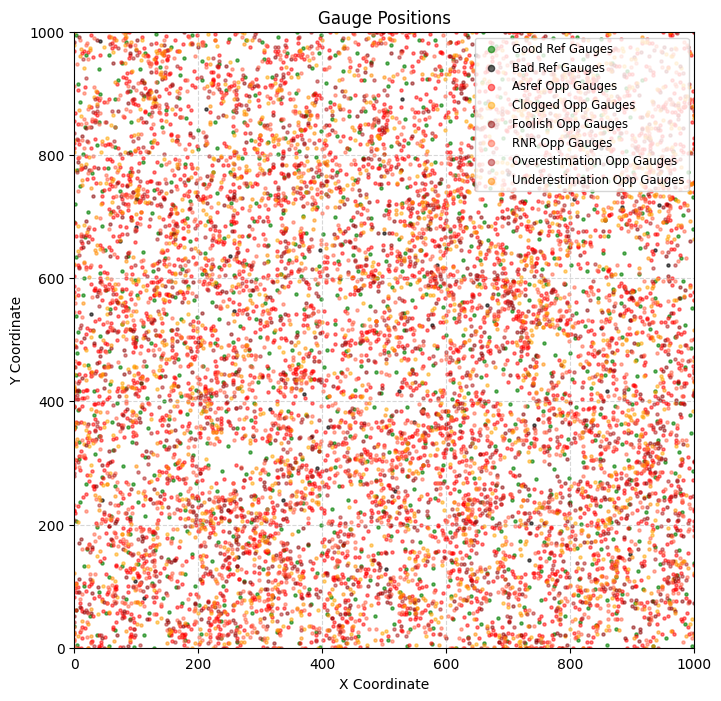

In [ ]:
# Re-import necessary libraries since the execution state was reset
import torch
import matplotlib.pyplot as plt

def plot_categorized_positions(
    good_ref, bad_ref, asref_opp, clogged_opp, foolish_opp, rnr_opp, overestimation_opp, underestimation_opp
):
    width, height = 1000, 1000

    plt.figure(figsize=(8, 8))
    plt.xlim(0, width)
    plt.ylim(0, height)
    size = 5
    # Plot reference gauges
    plt.scatter(good_ref[:, 0], good_ref[:, 1], s=size, alpha=0.6, c='green', label="Good Ref Gauges")
    plt.scatter(bad_ref[:, 0], bad_ref[:, 1], s=size, alpha=0.6, c='black', label="Bad Ref Gauges")

    # Plot opportunistic gauges in warm colors
    plt.scatter(asref_opp[:, 0], asref_opp[:, 1], s=size, alpha=0.5, c='red', label="Asref Opp Gauges")
    plt.scatter(clogged_opp[:, 0], clogged_opp[:, 1], s=size, alpha=0.5, c='orange', label="Clogged Opp Gauges")
    plt.scatter(foolish_opp[:, 0], foolish_opp[:, 1], s=size, alpha=0.5, c='darkred', label="Foolish Opp Gauges")
    plt.scatter(rnr_opp[:, 0], rnr_opp[:, 1], s=size, alpha=0.5, c='tomato', label="RNR Opp Gauges")
    plt.scatter(overestimation_opp[:, 0], overestimation_opp[:, 1], s=size, alpha=0.5, c='firebrick', label="Overestimation Opp Gauges")
    plt.scatter(underestimation_opp[:, 0], underestimation_opp[:, 1], s=size, alpha=0.5, c='darkorange', label="Underestimation Opp Gauges")

    plt.title("Gauge Positions")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.legend(loc="upper right", fontsize="small", markerscale=2.)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


# Plot the categorized gauge positions
plot_categorized_positions(
    good_ref_gauge_positions, bad_ref_gauge_positions,
    asref_opp_gauge_positions, clogged_opp_gauge_positions,
    foolish_opp_gauge_positions, rnr_opp_gauge_positions,
    overestimation_opp_gauge_positions, underestimation_opp_gauge_positions
)


In [ ]:
# Assign class labels
good_ref_labels = torch.full((good_ref_gauge_positions.shape[0], 1), 0, dtype=torch.int64)
bad_ref_labels = torch.full((bad_ref_gauge_positions.shape[0], 1), 1, dtype=torch.int64)
asref_opp_labels = torch.full((asref_opp_gauge_positions.shape[0], 1), 2, dtype=torch.int64)
clogged_opp_labels = torch.full((clogged_opp_gauge_positions.shape[0], 1), 3, dtype=torch.int64)
foolish_opp_labels = torch.full((foolish_opp_gauge_positions.shape[0], 1), 4, dtype=torch.int64)
rnr_opp_labels = torch.full((rnr_opp_gauge_positions.shape[0], 1), 5, dtype=torch.int64)
overestimation_opp_labels = torch.full((overestimation_opp_gauge_positions.shape[0], 1), 6, dtype=torch.int64)
underestimation_opp_labels = torch.full((underestimation_opp_gauge_positions.shape[0], 1), 7, dtype=torch.int64)

# Concatenate positions with their respective labels
good_ref_data = torch.cat((good_ref_gauge_positions, good_ref_labels), dim=1)
bad_ref_data = torch.cat((bad_ref_gauge_positions, bad_ref_labels), dim=1)
asref_opp_data = torch.cat((asref_opp_gauge_positions, asref_opp_labels), dim=1)
clogged_opp_data = torch.cat((clogged_opp_gauge_positions, clogged_opp_labels), dim=1)
foolish_opp_data = torch.cat((foolish_opp_gauge_positions, foolish_opp_labels), dim=1)
rnr_opp_data = torch.cat((rnr_opp_gauge_positions, rnr_opp_labels), dim=1)
overestimation_opp_data = torch.cat((overestimation_opp_gauge_positions, overestimation_opp_labels), dim=1)
underestimation_opp_data = torch.cat((underestimation_opp_gauge_positions, underestimation_opp_labels), dim=1)

# Combine all into a single tensor
all_gauge_data = torch.cat(
    (good_ref_data, bad_ref_data, asref_opp_data, clogged_opp_data,
     foolish_opp_data, rnr_opp_data, overestimation_opp_data, underestimation_opp_data), dim=0
)

print(all_gauge_data.shape)

torch.Size([11000, 3])


In [ ]:
import torch

# Define the threshold distance (integer sqrt(2 * 40^2))
radius = int((2*(32**2)) ** 0.5)

# Compute pairwise squared distances using broadcasting
coords = all_gauge_data[:, :2]  # Extract x, y positions only
diffs = coords.unsqueeze(1) - coords.unsqueeze(0)  # Compute (x_i - x_j), (y_i - y_j) for all pairs
dists_sq = (diffs ** 2).sum(dim=2)  # Compute squared Euclidean distance

# Find indices where distance is within threshold
within_range = dists_sq <= radius ** 2  # Boolean mask

# Create the neighborhood dictionary with k as the first element
nd = {}
for i in range(coords.shape[0]):
    neighbors = torch.where(within_range[i])[0].tolist()  # Get all neighbors
    if i in neighbors:
        neighbors.remove(i)  # Remove i if it's not at the first place
    else:
      raise()
    neighbors.insert(0, i)  # Ensure i is at the first position
    nd[i] = neighbors  # Store the reordered list

# Print a small sample of the neighborhood dictionary
sample_nd = {k: nd[k] for k in list(nd.keys())[:10]}
print(sample_nd)

{0: [0, 172, 186, 613, 674, 987, 1012, 1069, 1133, 1174, 1258, 1337, 1410, 1539, 1540, 1772, 1843, 1994, 2018, 2154, 2173, 2252, 2281, 2410, 2423, 2437, 2488, 2617, 2698, 2736, 2847, 2917, 3027, 3029, 3047, 3301, 3339, 3348, 3521, 3582, 3596, 3686, 4013, 4034, 4044, 4117, 4127, 4185, 4225, 4245, 4246, 4459, 4568, 4582, 4595, 4652, 4877, 5004, 5128, 5165, 5278, 5414, 5602, 5678, 5799, 5950, 6513, 6638, 6733, 6746, 6771, 7001, 7140, 7313, 7341, 7362, 7377, 7432, 7525, 7666, 7984, 7989, 8060, 8208, 8366, 8373, 8445, 8895, 8931, 9073, 9094, 9193, 9471, 9564, 9614, 9933, 9965, 10011, 10028, 10074, 10232, 10712, 10719, 10775], 1: [1, 227, 231, 374, 754, 936, 940, 1256, 1534, 1608, 1626, 1742, 1751, 1825, 1929, 2629, 3087, 3234, 3394, 4226, 4554, 4566, 4617, 4627, 4725, 4809, 5119, 5232, 5541, 5643, 5766, 6102, 6244, 6581, 6734, 6845, 6983, 7051, 7156, 7172, 7309, 7616, 7664, 7792, 7924, 7985, 8604, 8970, 9088, 9237, 9253, 9515, 9592, 9605, 9905, 10251, 10425, 10778, 10887], 2: [2, 68, 496, 5

In [ ]:
neighborhood_sizes = torch.tensor([len(v) for v in nd.values()])
max_len = neighborhood_sizes.max().item()  # Maximum list length
min_len = neighborhood_sizes.min().item()  # Minimum list length
mean_len = neighborhood_sizes.float().mean().item()  # Mean length
quantiles = torch.quantile(neighborhood_sizes.float(), torch.tensor([0.25, 0.5, 0.75])).tolist()  # Q1, median, Q3
print(f"Max length: {max_len}")
print(f"Min length: {min_len}")
print(f"Mean length: {mean_len:.2f}")
print(f"Q1 (25%): {quantiles[0]:.2f}")
print(f"Median (50%): {quantiles[1]:.2f}")
print(f"Q3 (75%): {quantiles[2]:.2f}")


Max length: 124
Min length: 17
Mean length: 71.41
Q1 (25%): 60.00
Median (50%): 71.00
Q3 (75%): 83.00


-> 350 gauges as inputs

In [ ]:
nd_stacked = {i: torch.tensor(neighbors, dtype=torch.int64) for i, neighbors in nd.items()}

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from fusion_2d_od.utile_denoising import gen
"""
class GaugeDataset(Dataset):
    def __init__(self, gauge_data, nd_stacked):
        self.gauge_data = gauge_data
        self.nd_stacked = nd_stacked
        self.image_size = 64
        self.center_shift = torch.tensor([32, 32], dtype=torch.long)
        self.limit_len = 100

    def __len__(self):
        return len(self.gauge_data)

    def __getitem__(self, idx):
        # Select neighbors
        gauges = self.nd_stacked[idx]
        gauges = self.gauge_data[gauges]
        # Apply centering with random shift
        shift = gauges[0, :2] + 0*torch.randint(-4, 5, (2,))
        gauges[:, :2] -= shift
        # Apply random rotation
        theta = torch.rand(1) * 2 * torch.pi

        rotation_matrix = torch.tensor([[torch.cos(theta), -torch.sin(theta)],
                                        [torch.sin(theta), torch.cos(theta)]], dtype=torch.float32)
        gauges[:, :2] = torch.mm(gauges[:, :2].float(), rotation_matrix).long()

        # Shift to center of picturlet
        gauges[:, :2] += self.center_shift
        # Prune out of bounds
        mask = ((gauges[:, 0] >= 0) & (gauges[:, 0] < self.image_size) &
                (gauges[:, 1] >= 0) & (gauges[:, 1] < self.image_size))
        gauges = gauges[mask]

        gauges = gauges[torch.randperm(gauges.shape[0]),:]
        ground_truth, _ = gen(1)
        ground_truth = ground_truth.squeeze(0).squeeze(0)

        # if perfect gauges (first experiment)
        # gauges[:,2] = 0
        gauges = self.sample_ground_truth(gauges, ground_truth)

        # Ensure tensor is collatable
        gauges = self.limit_gauge_tensor(gauges)
        return gauges, ground_truth


    def sample_ground_truth(self, gauges, ground_truth):
        # Sample ground truth values at gauge positions
        x_indices = gauges[:, 0].long().clamp(0, self.image_size - 1)
        y_indices = gauges[:, 1].long().clamp(0, self.image_size - 1)
        rain_rates = ground_truth[x_indices, y_indices]

        # Modify based on gauge class
        classes = gauges[:, 2].long()

        rain_rates[classes == 1] = 0  # Bad ref
        rain_rates[classes == 3] = 0  # Clogged
        rain_rates[classes == 4] = ground_truth[torch.randint(0, self.image_size, (1,)),
                                                torch.randint(0, self.image_size, (1,))]  # Foolish
        rain_rates[classes == 5] *= torch.rand((rain_rates[classes == 5].shape[0],), dtype=torch.float32) * 4.9 + 0.1  # RNR
        rain_rates[classes == 6] *= 2  # Overestimation
        rain_rates[classes == 7] /= 2  # Underestimation

        # Append rain rate as the fourth column
        gauges = torch.cat((gauges, rain_rates.unsqueeze(1)), dim=1)
        return gauges

    def limit_gauge_tensor(self, gauges):
        num_gauges = gauges.shape[0]

        if num_gauges > self.limit_len:
            gauges = gauges[:self.limit_len]
        elif num_gauges < self.limit_len:
            deficit = self.limit_len - num_gauges
            padding = torch.tensor([[-1, -1, -1, -0.1]] * deficit, dtype=torch.float32)
            gauges = torch.cat((gauges, padding), dim=0)
            gauges = gauges[torch.randperm(gauges.shape[0]),:]
        return gauges

# Instantiate dataset
gauge_dataset = GaugeDataset(all_gauge_data, nd_stacked)
"""

class GaugeDataset(Dataset):
    def __init__(self, gauge_data, nd_stacked):
        self.gauge_data = gauge_data
        self.nd_stacked = nd_stacked
        self.image_size = 64
        self.center_shift = torch.tensor([32, 32], dtype=torch.long)
        self.limit_len = 100

    def __len__(self):
        return len(self.gauge_data)

    def __getitem__(self, idx):
        # Select neighbors
        gauges = self.nd_stacked[idx]
        gauges = torch.cat((gauges.unsqueeze(1),  self.gauge_data[gauges]), dim=1)
        # Apply centering with random shift
        gauges[:, 1:3] -= gauges[0, 1:3] + 0*torch.randint(-4, 5, (2,))

        # Apply random rotation
        theta = torch.rand(1) * 2 * torch.pi

        rotation_matrix = torch.tensor([[torch.cos(theta), -torch.sin(theta)],
                                        [torch.sin(theta), torch.cos(theta)]], dtype=torch.float32)
        gauges[:, 1:3] = torch.mm(gauges[:, 1:3].float(), rotation_matrix).long()

        # Shift to center of picturlet
        gauges[:, 1:3] += self.center_shift
        # Prune out of bounds
        mask = ((gauges[:, 1] >= 0) & (gauges[:, 1] < self.image_size) &
                (gauges[:, 2] >= 0) & (gauges[:, 2] < self.image_size))
        gauges = gauges[mask]


        ground_truth, _ = gen(1)
        ground_truth = ground_truth.squeeze(0).squeeze(0)

        # if perfect gauges (first experiment)
        # gauges[:,2] = 0
        gauges = self.sample_ground_truth(gauges, ground_truth)

        # Ensure tensor is collatable
        gauges = self.limit_gauge_tensor(gauges)

        # Permute the order
        gauges = gauges[torch.randperm(gauges.shape[0]),:]
        return gauges, ground_truth


    def sample_ground_truth(self, gauges, ground_truth):
        # Sample ground truth values at gauge positions
        x_indices = gauges[:, 1].long().clamp(0, self.image_size - 1)
        y_indices = gauges[:, 2].long().clamp(0, self.image_size - 1)
        rain_rates = ground_truth[x_indices, y_indices]

        # Modify based on gauge class
        classes = gauges[:, 3].long()

        rain_rates[classes == 1] = 0  # Bad ref
        rain_rates[classes == 3] = 0  # Clogged
        rain_rates[classes == 4] = ground_truth[torch.randint(0, self.image_size, (1,)),
                                                torch.randint(0, self.image_size, (1,))]  # Foolish
        rain_rates[classes == 5] *= torch.rand((rain_rates[classes == 5].shape[0],), dtype=torch.float32) * 4.9 + 0.1  # RNR
        rain_rates[classes == 6] *= 2  # Overestimation
        rain_rates[classes == 7] /= 2  # Underestimation

        # Append rain rate as the fourth column
        gauges = torch.cat((gauges, rain_rates.unsqueeze(1)), dim=1)
        return gauges

    def limit_gauge_tensor(self, gauges):
        num_gauges = gauges.shape[0]

        if num_gauges > self.limit_len:
            gauges = gauges[:self.limit_len]
        elif num_gauges < self.limit_len:
            deficit = self.limit_len - num_gauges
            padding = torch.tensor([[-1, -1, -1, -1, -0.1]] * deficit, dtype=torch.float32)
            gauges = torch.cat((gauges, padding), dim=0)
        return gauges

# Instantiate dataset
gauge_dataset = GaugeDataset(all_gauge_data, nd_stacked)

NameError: name 'all_gauge_data' is not defined

In [ ]:
gauge_loader = DataLoader(gauge_dataset, batch_size=64, shuffle=True, num_workers=2)
it = iter(gauge_loader)

In [ ]:
%%timeit -r 1 -n 1
for i, a in enumerate(gauge_loader):
  if i%100 == 0:
    print(i)

0
100
36.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


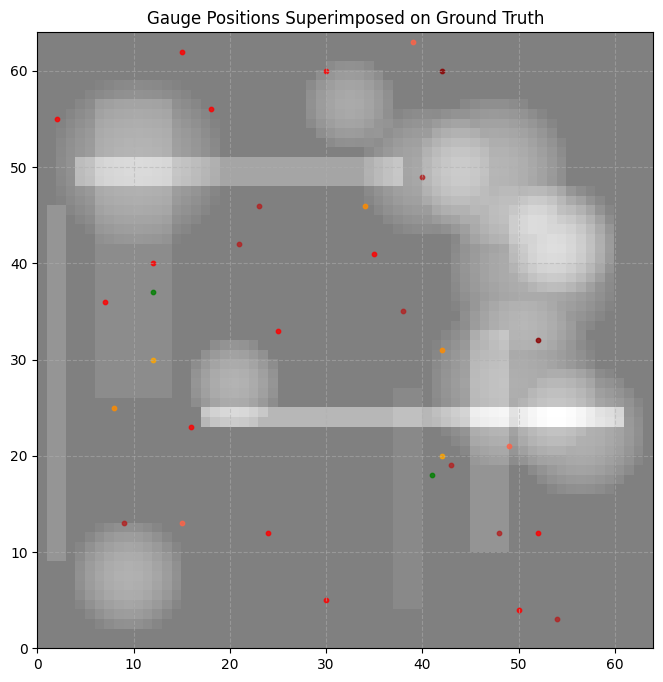

In [ ]:
# Iterate dataset and visualize
plt.figure(figsize=(8, 8))
colors = {0: 'green', 1: 'black', 2: 'red', 3: 'orange', 4: 'darkred', 5: 'tomato', 6: 'firebrick', 7: 'darkorange'}


gauges, ground_truth = next(it)

# Display ground truth as dimmed background
plt.imshow(ground_truth[0].numpy(), cmap='gray', alpha=0.5, extent=[0, 64, 0, 64])

# Scatter plot of gauges
for gauge in gauges:
    id, x, y, cls = gauge[0].tolist()[:4]
    plt.scatter(x, y, s=10, alpha=0.8, c=colors.get(int(cls), 'gray'))

plt.xlim(0, 64)
plt.ylim(0, 64)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Gauge Positions Superimposed on Ground Truth")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
'''
class TinyTransformer(nn.Module):
    def __init__(self, num_classes=8, d_model=128, nhead=4, num_layers=6):
        super(TinyTransformer, self).__init__()
        self.d_model = d_model

        # Positional Encoding for (x, y) coordinates
        self.pos_embedding = nn.Linear(2, d_model // 2)

        # Class + Value Embedding
        self.class_embedding = nn.Embedding(num_classes, d_model // 4)
        self.value_embedding = nn.Linear(1, d_model // 4)

        # Transformer layers
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward=64, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)

        # Output layer (probability of class + rain rate value)
        self.fc_out = nn.Linear(d_model, 2)

    def forward(self, x):
        pos_emb = self.pos_embedding(x[:, :, :2])

        # Mask to ignore class -1
        valid_mask = x[:, :, 2] >= 0

        # Initialize class embedding tensor
        class_emb = torch.zeros(x.shape[0], x.shape[1], self.class_embedding.embedding_dim, device=x.device)

        # Apply class embedding only where class is valid
        valid_classes = x[:, :, 2].long().clamp(0, self.class_embedding.num_embeddings - 1)
        class_emb[valid_mask] = self.class_embedding(valid_classes[valid_mask])

        value_emb = self.value_embedding(x[:, :, 3].unsqueeze(-1))

        # Concatenate embeddings
        x_emb = torch.cat([pos_emb, class_emb, value_emb], dim=-1)

        # Pass through transformer
        x_transformed = self.transformer(x_emb)

        # Output prediction
        output = self.fc_out(x_transformed)
        return output
'''
import torch
import torch.nn as nn

class TinyTransformerBlock(nn.Module):
    def __init__(self, d_model, nhead, norm_type="layernorm"):
        super(TinyTransformerBlock, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, batch_first=True)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.ReLU(),
            nn.Linear(4 * d_model, d_model)
        )

        # Select normalization type (Pre-Norm applied)
        if norm_type == "layernorm":
            self.norm1 = nn.LayerNorm(d_model)
            self.norm2 = nn.LayerNorm(d_model)
        elif norm_type == "rmsnorm":
            self.norm1 = nn.RMSNorm(d_model)
            self.norm2 = nn.RMSNorm(d_model)
        elif norm_type == "graphnorm":
            self.norm1 = nn.GraphNorm(d_model)
            self.norm2 = nn.GraphNorm(d_model)
        elif norm_type == "batchnorm":
            self.norm1 = nn.BatchNorm1d(d_model)
            self.norm2 = nn.BatchNorm1d(d_model)
        elif norm_type == "instancenorm":
            self.norm1 = nn.InstanceNorm1d(d_model)
            self.norm2 = nn.InstanceNorm1d(d_model)
        else:
            raise ValueError("Unsupported normalization type.")

    def forward(self, x):
        if isinstance(self.norm1, nn.BatchNorm1d) or isinstance(self.norm1, nn.InstanceNorm1d):
            x = x.permute(0, 2, 1)  # (B, N, D) → (B, D, N) for BatchNorm
            x = self.norm1(x)
            x = x.permute(0, 2, 1)  # (B, D, N) → (B, N, D)
        else:
            x = self.norm1(x)

        x = x + self.self_attn(x, x, x)[0]

        if isinstance(self.norm2, nn.BatchNorm1d) or isinstance(self.norm1, nn.InstanceNorm1d):
          x = x.permute(0, 2, 1)  # (B, N, D) → (B, D, N) for BatchNorm
          x = self.norm2(x)
          x = x.permute(0, 2, 1)  # (B, D, N) → (B, N, D)
        else:
          x = self.norm2(x)

        x = x + self.ffn(x)  # Pre-Norm before FeedForward
        return x

class TinyTransformer(nn.Module):
    def __init__(self, num_classes=8, d_model=128, nhead=4, num_layers=6, norm_type="layernorm"):
        super(TinyTransformer, self).__init__()
        self.d_model = d_model

        # Positional Encoding for (x, y) coordinates
        self.pos_embedding = nn.Linear(2, d_model // 2)

        # Class + Value Embedding
        self.class_embedding = nn.Embedding(num_classes, d_model // 4)
        self.value_embedding = nn.Linear(1, d_model // 4)

        # Transformer Layers with configurable Pre-Norm
        self.layers = nn.ModuleList([
            TinyTransformerBlock(d_model, nhead, norm_type) for _ in range(num_layers)
        ])

        self.fc_out = nn.Linear(d_model, 2)

    def forward(self, x):
        pos_emb = self.pos_embedding(x[:, :, :2])
        valid_mask = x[:, :, 2] >= 0
        class_emb = torch.zeros(x.shape[0], x.shape[1], self.class_embedding.embedding_dim, device=x.device)
        valid_classes = x[:, :, 2].long().clamp(0, self.class_embedding.num_embeddings - 1)
        class_emb[valid_mask] = self.class_embedding(valid_classes[valid_mask])
        value_emb = self.value_embedding(x[:, :, 3].unsqueeze(-1))

        # Concatenate embeddings
        x_emb = torch.cat([pos_emb, class_emb, value_emb], dim=-1)

        # Pass through Transformer Blocks
        for layer in self.layers:
            x_emb = layer(x_emb)

        return self.fc_out(x_emb)


class TinyTransformer_specific_weights(nn.Module):
    def __init__(self, num_classes=8, d_model=128, nhead=4, num_layers=6, norm_type="layernorm"):
        super(TinyTransformer_specific_weights, self).__init__()
        self.d_model = d_model

        # Positional Encoding for (x, y) coordinates
        self.pos_embedding = nn.Linear(2, d_model // 2)

        # Class Embedding
        class_vectors = 0.3*torch.randn(11001, 2)
        class_vectors[0] -= 0.5
        class_vectors[1:1001] += 0.5
        self.classes = nn.Parameter(class_vectors)
        self.class_embedding = nn.Linear(2, d_model // 4)

        # Value Embedding
        self.value_embedding = nn.Linear(1, d_model // 4)

        # Transformer Layers with configurable Pre-Norm
        self.layers = nn.ModuleList([
            TinyTransformerBlock(d_model, nhead, norm_type) for _ in range(num_layers)
        ])

        self.fc_out = nn.Linear(d_model, 2)

    def forward(self, x):
        pos_emb = self.pos_embedding(x[:, :, 1:3])

        # valid_mask = x[:, :, 2] >= 0
        # class_emb = torch.zeros(x.shape[0], x.shape[1], self.class_embedding.embedding_dim, device=x.device)
        # valid_classes = x[:, :, 2].long().clamp(0, self.class_embedding.num_embeddings - 1)
        #☺ class_emb[valid_mask] = self.class_embedding(valid_classes[valid_mask])
        class_vectors = self.classes[1 + x[:, :, 0].long(), :]
        noise = torch.normal(mean=torch.zeros_like(class_vectors),
                             std=0.25*torch.ones_like(class_vectors))
        class_vectors += noise
        class_emb = self.class_embedding(class_vectors)

        value_emb = self.value_embedding(x[:, :, 4].unsqueeze(-1))

        # Concatenate embeddings
        x_emb = torch.cat([pos_emb, class_emb, value_emb], dim=-1)

        # Pass through Transformer Blocks
        for layer in self.layers:
            x_emb = layer(x_emb)

        return self.fc_out(x_emb)



# Function to partition gauges
"""
def part_gauges(xy, eval=False):
    bs, num_points, _ = xy.shape
    device = xy.device

    # Generate random Ki values for each batch element
    Ki_values = torch.randint(10, 90, (bs,), device=device)

    # Create a batch-wise mask (bs x num_points)
    random_indices = torch.rand(bs, num_points, device=device).argsort(dim=1)  # Shuffle points
    mask = torch.arange(num_points, device=device).expand(bs, num_points) < Ki_values.unsqueeze(1)  # Create boolean mask
    mask = torch.gather(mask, dim=1, index=random_indices)  # Apply random permutation

    # Clone xy to form x and y
    x, y = xy.clone(), xy.clone()

    # Apply mask to set values to -0.1 (apply to the last dimension only)
    x[:, :, 3][~mask] = -0.1  # Mask target values in x (inputs)
    # y[:, :, 3][mask] = -0.1  # Mask input values in y (targets)
    if eval == True:
      x = y
    return x, y
"""
def part_gauges(xy, eval=False):
    bs, num_points, _ = xy.shape
    device = xy.device

    # Generate random Ki values for each batch element
    Ki_values = torch.randint(10, 90, (bs,), device=device)

    # Create a batch-wise mask (bs x num_points)
    random_indices = torch.rand(bs, num_points, device=device).argsort(dim=1)  # Shuffle points
    mask = torch.arange(num_points, device=device).expand(bs, num_points) < Ki_values.unsqueeze(1)  # Create boolean mask
    mask = torch.gather(mask, dim=1, index=random_indices)  # Apply random permutation

    # Clone xy to form x and y
    x, y = xy.clone(), xy.clone()

    # Apply mask to set values to -0.1 (apply to the last dimension only)
    x[:, :, 4][~mask] = -0.1  # Mask target values in x (inputs)
    if eval == True:
      x = y
    return x, y
from torch.optim.lr_scheduler import LambdaLR

def lr_lambda(epoch):
    return min(1.0, (epoch + 1) / 20.)  # Linearly scale up for first 20 epochs

# Training loop
"""
def train_transformer(model, dataloader, num_epochs=10, lr=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.L1Loss(reduction='none')  # MAE
    scheduler = LambdaLR(optimizer, lr_lambda)

    for epoch in range(num_epochs):
        model.train()
        total_loss, count = 0, 0

        for k, batch in enumerate(dataloader):
            if k % 100 == 0:
              print(k)
            gauges, _ = batch
            gauges = gauges.to(device)
            x, y = part_gauges(gauges)
            x, y = x.to(device), y.to(device)
            x[:,:2] = 1./64 * x[:,:2]
            x[:,3] = 1./10 * x[:,3]
            optimizer.zero_grad()

            pred = model(x)
            mask = (y[:, :, 3] > -0.1)
            loss = torch.abs((pred[:, :, 1] - y[:, :, 3])[mask])
            loss = loss.mean()

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            count += 1

        print(f"Epoch {epoch + 1}, MAE: {total_loss / count:.4f}")
        scheduler.step()
    return model
"""


'\ndef train_transformer(model, dataloader, num_epochs=10, lr=1e-4):\n    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")\n    model.to(device)\n    optimizer = optim.Adam(model.parameters(), lr=lr)\n    loss_fn = nn.L1Loss(reduction=\'none\')  # MAE\n    scheduler = LambdaLR(optimizer, lr_lambda)\n\n    for epoch in range(num_epochs):\n        model.train()\n        total_loss, count = 0, 0\n\n        for k, batch in enumerate(dataloader):\n            if k % 100 == 0:\n              print(k)\n            gauges, _ = batch\n            gauges = gauges.to(device)\n            x, y = part_gauges(gauges)\n            x, y = x.to(device), y.to(device)\n            x[:,:2] = 1./64 * x[:,:2]\n            x[:,3] = 1./10 * x[:,3]\n            optimizer.zero_grad()\n\n            pred = model(x)\n            mask = (y[:, :, 3] > -0.1)\n            loss = torch.abs((pred[:, :, 1] - y[:, :, 3])[mask])\n            loss = loss.mean()\n\n            loss.backward()\n         

In [ ]:
# Create model and loader " première expérence : 0.0390 en 200 ep 0.0384 en 500 ep 1000 ep -> 0.038 (FCN: 100 ep : 0.036)"
# tiny_transformer = TinyTransformer(norm_type="batchnorm")
model = TinyTransformer_specific_weights(norm_type="batchnorm")
gauge_loader = DataLoader(gauge_dataset, batch_size=64, shuffle=True, num_workers=2)
# optimizer = optim.Adam(model.parameters(), lr=10e-4)
optimizer = torch.optim.Adam([
    {'params': model.layers.parameters(), 'lr': 1e-4},  # Lower for stable features
    {'params': model.pos_embedding.parameters(), 'lr': 1e-4},  # Lower for stable features
    {'params': model.value_embedding.parameters(), 'lr': 1e-4},  # Lower for stable features
    {'params': model.class_embedding.parameters(), 'lr': 1e-4},  # Lower for stable features
    {'params': model.fc_out.parameters(), 'lr': 3e-4},  # Higher to speed up adaptation
    {'params': model.classes, 'lr': 1e-5}  # Even higher for embedding vectors
])
scheduler = LambdaLR(optimizer, lr_lambda)
loss_fn = nn.L1Loss(reduction='none')  # MAE

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
num_part_gauges = 3
num_epochs = 500

for epoch in range(num_epochs):
    model.train()
    total_loss, count = 0, 0

    for k, batch in enumerate(gauge_loader):
        if k % 100 == 0:
          print(k)
        gauges, _ = batch
        gauges = gauges.to(device)
        loss = 0.
        for _ in range(num_part_gauges):
          x, y = part_gauges(gauges)
          x, y = x.to(device), y.to(device)
          x[:,:,1:3] = 1./64 * x[:,:,1:3]

          optimizer.zero_grad()

          pred = model(x)
          mask = (y[:, :, 4] > -0.1)
          partial_loss = torch.abs((pred[:, :, 0] - y[:, :, 4])[mask])
          loss += partial_loss.mean()

        loss.backward()
        optimizer.step()

        total_loss += loss.item() / num_part_gauges
        count += 1

    print(f"Epoch {epoch + 1}, MAE: {total_loss / count:.4f}")
    scheduler.step()

0
100
Epoch 1, MAE: 0.1692
0
100
Epoch 2, MAE: 0.0978
0
100
Epoch 3, MAE: 0.0872
0
100
Epoch 4, MAE: 0.0817
0
100
Epoch 5, MAE: 0.0788
0
100
Epoch 6, MAE: 0.0779
0
100
Epoch 7, MAE: 0.0765
0
100
Epoch 8, MAE: 0.0751
0
100
Epoch 9, MAE: 0.0765
0
100
Epoch 10, MAE: 0.0744
0
100
Epoch 11, MAE: 0.0728
0
100
Epoch 12, MAE: 0.0732
0
100
Epoch 13, MAE: 0.0734
0
100
Epoch 14, MAE: 0.0702
0
100
Epoch 15, MAE: 0.0698
0
100
Epoch 16, MAE: 0.0717
0
100
Epoch 17, MAE: 0.0701
0
100
Epoch 18, MAE: 0.0709
0
100
Epoch 19, MAE: 0.0702
0
100
Epoch 20, MAE: 0.0694
0
100
Epoch 21, MAE: 0.0702
0
100
Epoch 22, MAE: 0.0684
0
100
Epoch 23, MAE: 0.0668
0
100
Epoch 24, MAE: 0.0675
0
100
Epoch 25, MAE: 0.0663
0
100
Epoch 26, MAE: 0.0651
0
100
Epoch 27, MAE: 0.0651
0
100
Epoch 28, MAE: 0.0652
0
100
Epoch 29, MAE: 0.0643
0
100
Epoch 30, MAE: 0.0657
0
100
Epoch 31, MAE: 0.0644
0
100
Epoch 32, MAE: 0.0650
0
100
Epoch 33, MAE: 0.0649
0
100
Epoch 34, MAE: 0.0632
0
100
Epoch 35, MAE: 0.0643
0
100
Epoch 36, MAE: 0.0649
0

In [ ]:
# Re-import necessary libraries since execution state was reset
import torch
import matplotlib.pyplot as plt

# Assuming model.classes is a N x 2 tensor with (x, y) positions
# and all_gauge_data[:, 2] contains the corresponding class labels

# Placeholder for model.classes and all_gauge_data since state was reset
# In practice, these should be retrieved from the trained model and dataset
N = 1000  # Example number of gauges
model_classes = model.classes.cpu().detach()[1:,]  # Simulated (x, y) positions
# all_gauge_data = torch.randint(0, 8, (N, 3))  # Simulated class labels in column 2

# Convert to numpy for plotting
gauge_positions = model_classes.numpy()
gauge_labels = all_gauge_data[:, 2].numpy()

# Define color mapping
colors = {
    0: 'green', 1: 'black', 2: 'red', 3: 'orange',
    4: 'darkred', 5: 'tomato', 6: 'firebrick', 7: 'darkorange'
}

# Create scatter plot
plt.figure(figsize=(8, 8))
for class_label, color in colors.items():
    mask = (gauge_labels == class_label)
    plt.scatter(
        gauge_positions[mask, 0], gauge_positions[mask, 1],
        s=5, alpha=0.6, c=color, label=f"Class {class_label}"
    )

# Legend
plt.xlim(0, 1000)
plt.ylim(0, 1000)
plt.legend()
plt.title("Scatterplot of Model Classes with Clustering")
plt.show()


tensor([    0,     1,     1,     0,  8369,  3271,  4870,  9488, 10217,     0,
         4339,     0,     0,     0,     0,  8071,     0,     0,     0,     0,
         2145,     0,  5544,     0,  7556,     0,     0,     0,  3694,     0,
          461,     0,     0,     0,  8084,     0,   279,     0,    43,  7661,
            0,     0,     0,  3706,  3829,     0,  1392,  8016,  6544,     0,
            0,  2898,     0,   813,  8915,     0,  2708,  6493, 10416,  1533,
            0,     0,     0,  1776,     0,     0,  8098,  1239,     0,     0,
         5925,     0,     0,  3172,  4771,  1430,  3260,  5229,  3979,  6144,
            0,     0,  7077,     0, 10245,  8773,  8075,   133,     0,     0,
            0,     0,     0,  6147,     0,  3657,     0,     0, 10397,     0])

In [ ]:
# Train model
# model = train_transformer(tiny_transformer, gauge_loader, num_epochs=1000)
# Atteint

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x790fe0197920>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1568, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 948, in wait
    ready = selector.select(timeout)
            ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
     

0


KeyboardInterrupt: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


save_path = "/content/drive/My Drive/transformer_weights.pth"


torch.save(model.state_dict(), save_path)
print(f"Model weights saved to {save_path}")


Mounted at /content/drive


NameError: name 'model' is not defined

## A. Traitement par FCN : cas où tous les pluvios sont à zéro

In [ ]:
ground_truth.shape

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np


def project_to_grid(x, y):
    bs, num_points, _ = x.shape
    device = x.device

    # Initialize tensors with -0.1
    proj_x = torch.full((bs, 2, 64, 64), -0.1, device=device)
    proj_y = torch.full((bs, 1, 64, 64), -0.1, device=device)

    # Get valid indices for x
    valid_mask_x = (x[:, :, :3] != -1).all(dim=2)
    batch_idx_x = torch.arange(bs, device=device).unsqueeze(1).expand(bs, num_points)[valid_mask_x]
    indices_x = x[:, :, :2].long()[valid_mask_x]

    # Fill proj_x using advanced indexing
    proj_x[batch_idx_x, 0, indices_x[:, 0], indices_x[:, 1]] = x[:, :, 2][valid_mask_x]  # Class info
    proj_x[batch_idx_x, 1, indices_x[:, 0], indices_x[:, 1]] = x[:, :, 3][valid_mask_x]  # Input values

    # Get valid indices for y
    valid_mask_y = (y[:, :, 3] != -0.1)
    batch_idx_y = torch.arange(bs, device=device).unsqueeze(1).expand(bs, num_points)[valid_mask_y]
    indices_y = y[:, :, :2].long()[valid_mask_y]

    # Fill proj_y using advanced indexing
    proj_y[batch_idx_y, 0, indices_y[:, 0], indices_y[:, 1]] = y[:, :, 3][valid_mask_y]

    return proj_x, proj_y



# Loss function
def masked_mae_loss(pred, target):
    mask = target != -0.1
    loss = torch.abs(pred - target)[mask]
    return loss.mean()

# Visualization function
def visualize_unet_output(model, dataloader):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    with torch.no_grad():
        for batch in dataloader:
            gauges, ground_truth = batch

            gauges = gauges.to(device)
            x, y = part_gauges(gauges)
            x, y = x.to(device), y.to(device)

            proj_x, proj_y = project_to_grid(x, y)
            proj_x[:,1] /= 10.
            pred = model(proj_x)

            # Convert to numpy for visualization
            proj_x = proj_x.cpu().numpy()[0, 1]  # Input values
            proj_y = proj_y.cpu().numpy()[0, 0]  # Target values
            pred = pred.cpu().numpy()[0, 0]  # Predictions

            # Plot results
            fig, ax = plt.subplots(1, 4, figsize=(15, 5))
            ax[0].imshow(proj_x, cmap='jet', vmin=-0.1, vmax = 0.5)
            ax[0].set_title("Input Field")
            ax[1].imshow(proj_y, cmap='jet', vmin=-0.1, vmax = 0.5)
            ax[1].set_title("Target Field")
            ax[2].imshow(pred, cmap='jet', vmin=-0.1, vmax = 0.5)
            ax[2].set_title("Predicted Field")
            ax[3].imshow(ground_truth.cpu().numpy()[0], cmap='jet', vmin=-0.1, vmax = 0.5)
            ax[3].set_title("Predicted Field")
            plt.show()
            print(proj_x.shape, ground_truth.shape)
            print(proj_x[proj_x>= 0], ground_truth[0][proj_x>= 0] )
            break  # Visualize only one batch
    return gauges, ground_truth, x, y, proj_x, proj_y




/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


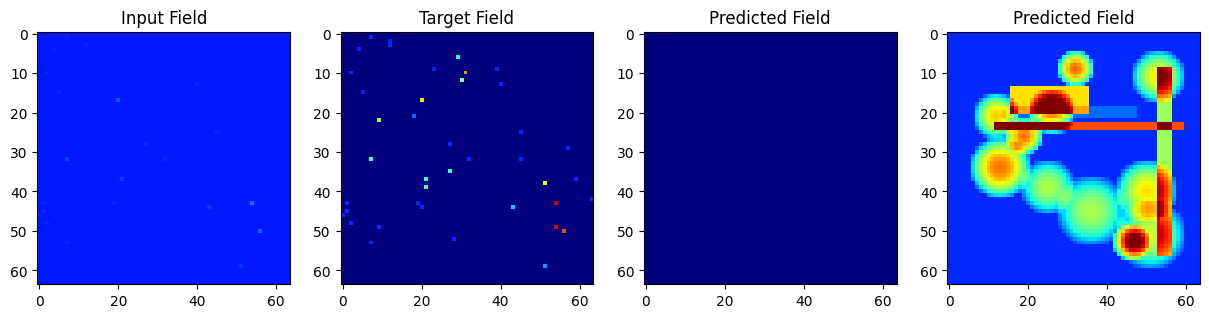

(64, 64) torch.Size([1, 64, 64])
[0.         0.         0.         0.         0.         0.
 0.03009361 0.         0.         0.01581135 0.         0.0148197
 0.         0.         0.04605694 0.01013058 0.         0.
 0.         0.04048248 0.         0.00702699] tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3009, 0.0000, 0.0000,
        0.1581, 0.0000, 0.1482, 0.0000, 0.0000, 0.4606, 0.1013, 0.0000, 0.0000,
        0.0000, 0.4048, 0.0000, 0.0703])


In [ ]:
# Create UNet model and loader
from fusion_2d_od.utile_denoising import UNet

ch_in = 2
ch_out = 1
size = 16

# Instanciation :
model = UNet(ch_in, ch_out, size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
gauge_loader = DataLoader(gauge_dataset, batch_size=1, shuffle=True, num_workers=4)
gauges, ground_truth, x, y, proj_x, proj_y = visualize_unet_output(model, gauge_loader)

In [ ]:
# Training loop
gauge_loader = DataLoader(gauge_dataset, batch_size=64, shuffle=True, num_workers=2)
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    count = 0

    for batch in gauge_loader:
        gauges, _ = batch
        gauges = gauges.to(device)
        x, y = part_gauges(gauges)
        proj_x, proj_y = project_to_grid(x, y)
        proj_x[:,1] /= 10.
        optimizer.zero_grad()
        pred = model(proj_x)
        loss = masked_mae_loss(pred, proj_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        count += 1

    print(f"Epoch {epoch + 1}, MAE: {total_loss / count:.4f}")

Epoch 1, MAE: 0.0368
Epoch 2, MAE: 0.0369
Epoch 3, MAE: 0.0371
Epoch 4, MAE: 0.0363
Epoch 5, MAE: 0.0364
Epoch 6, MAE: 0.0368
Epoch 7, MAE: 0.0370
Epoch 8, MAE: 0.0370
Epoch 9, MAE: 0.0370
Epoch 10, MAE: 0.0373
Epoch 11, MAE: 0.0372
Epoch 12, MAE: 0.0372
Epoch 13, MAE: 0.0371
Epoch 14, MAE: 0.0371
Epoch 15, MAE: 0.0371
Epoch 16, MAE: 0.0367
Epoch 17, MAE: 0.0372
Epoch 18, MAE: 0.0369
Epoch 19, MAE: 0.0371
Epoch 20, MAE: 0.0370
Epoch 21, MAE: 0.0367


In [ ]:
model

NameError: name 'model' is not defined

In [ ]:
proj_y.max()

In [ ]:
model.eval()

with torch.no_grad():
    for batch in gauge_loader:
        gauges, ground_truth = batch

        gauges = gauges.to(device)
        x, y = part_gauges(gauges, eval=True)
        x, y = x.to(device), y.to(device)

        proj_x, proj_y = project_to_grid(x, y)

        proj_x[:,1] /= 10.
        pred = model(proj_x)

        # Convert to numpy for visualization
        proj_x = proj_x.cpu().numpy()[0, 1]  # Input values
        proj_y = proj_y.cpu().numpy()[0, 0]  # Target values
        pred = pred.cpu().numpy()[0, 0]  # Predictions

        # Plot results
        fig, ax = plt.subplots(1, 4, figsize=(15, 5))
        ax[0].imshow(proj_x, cmap='jet', vmin=-0.01, vmax = 0.05)
        ax[0].set_title("Input Field")
        ax[1].imshow(proj_y, cmap='jet', vmin=-0.1, vmax = 0.5)
        ax[1].set_title("Target Field")
        ax[2].imshow(pred, cmap='jet', vmin=-0.1, vmax = 0.5)
        ax[2].set_title("Predicted Field")
        ax[3].imshow(ground_truth.cpu().numpy()[0], cmap='jet', vmin=-0.1, vmax = 0.5)
        ax[3].set_title("Predicted Field")
        plt.show()
        print(proj_x.shape, ground_truth.shape)
        print(proj_x[proj_x>= 0], ground_truth[0][proj_x>= 0] )
        break  # Visualize only one batch

In [ ]:
proj_x.shape

In [ ]:
lamedeau, pluviometres, radar, cmls_spatialises, cmls = gen_image_with_pairs(6, n_pairs, n_points)
pluviometres_spatialises =  -0.1 * torch.ones(radar.shape)
pluviometres_spatialises = set_tensor_values(pluviometres_spatialises, pluviometres, 64)
input = torch.cat([radar, pluviometres_spatialises, cmls_spatialises], dim = 1)
print(input.shape)

B. FCN, cas où on n'a que trois classes et où tous les pixels sont renseignés et où les capteurs sont utilisés en rotation

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(Up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch, in_ch, kernel_size=2, stride=2)
        self.conv = double_conv(2*in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x




def make_sensor_indices(batch_size, img_size=64, device=torch.device('cpu')):
    total_pixels = img_size * img_size

    # Generate a batch of independently shuffled indices
    indices = torch.stack([torch.randperm(total_pixels, device=device) for _ in range(batch_size)])

    # Reshape into (batch_size, img_size, img_size)
    return indices.view(batch_size, img_size, img_size)


def loss_masked_mae(pred, target, mask):
    masked_loss = torch.abs(pred - target) * mask
    eps = 10e-6
    return masked_loss.sum() / (mask.sum() + eps)

In [113]:


class UNet_odf(nn.Module): #odf : opportunistic data fusion
    def __init__(self, n_channels, n_classes, size=64):
        super(UNet_odf, self).__init__()

        # Learnable parameters for sensor reliability
        # sp = torch.randn(64*64, 2)
        sp = torch.zeros(64*64, 2).cuda()
        sp[:400] += 0.1
        self.sensors_param = sp #nn.Parameter(sp)

        self.inc = inconv(n_channels, size)
        self.down1 = Down(size, 2*size)
        self.down2 = Down(2*size, 4*size)
        self.down3 = Down(4*size, 8*size)
        self.down4 = Down(8*size, 8*size)
        self.up1 = Up(8*size, 4*size)
        self.up2 = Up(4*size, 2*size)
        self.up3 = Up(2*size, size)
        self.up4 = Up(size, size)
        self.outc = outconv(size, n_classes)

    def forward(self, x, sensor_indices):
        batch_size = x.shape[0]
        noise = torch.randn(self.sensors_param.shape, device=x.device)
        noisy_sensors_param = self.sensors_param + noise

        # supplementary_channels = noisy_sensors_param[sensor_indices.flatten()].view(list(x.shape) + [2]).transpose(1,4).squeeze(4)
        # tant qu'on est pas parvenu à tuer les scores:
        # supplementary_channels *= 0
        # x = torch.cat([x, supplementary_channels], dim=1)  # Concatenate with input image

        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x, self.sensors_param


In [115]:
num_known_good_gauges = 40
num_good_gauges = 400
noise_coeff = 0.1

model = UNet_odf(3, 1, 64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [116]:
from fusion_2d_od.utile_denoising import gen
device = torch.device('cuda:0') #torch.device('cuda:0')
model.to(device)
loss_history = []
num_epochs = 50
num_batch_per_epoch = 100
batch_size = 256

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0.0  # Track global epoch loss
    for i in range(num_batch_per_epoch):
        # Generate a batch of images
        images, _  = gen(batch_size)
        # print(images.mean())
        with torch.no_grad():
          fake_images, _ = gen(batch_size)
          images = images.to(device)
          fake_images = fake_images.to(device)
          batched_shuffled_matrices = make_sensor_indices(batch_size,img_size=64,device=device).unsqueeze(1)
          # Construction des inputs & targets
          # inputs = noise_coeff * torch.rand(images.shape, device=device) # + F.relu(0.1 * torch.randn(images.shape))
          inputs = images.flatten()[torch.randperm(images.numel())].reshape(images.shape)
          # inputs = torch.zeros(images.shape, device=device)
          inputs[(batched_shuffled_matrices < num_good_gauges) * (batched_shuffled_matrices >= num_known_good_gauges // 2)] = \
                images[(batched_shuffled_matrices < num_good_gauges) * (batched_shuffled_matrices >= num_known_good_gauges // 2)]
          inputs[batched_shuffled_matrices >= 64**2 - num_good_gauges] = fake_images[batched_shuffled_matrices  >= 64**2 - num_good_gauges]
          targets_mask = batched_shuffled_matrices < num_known_good_gauges // 2
        inputs = torch.cat([inputs, 0.5 * (batched_shuffled_matrices < num_good_gauges), 0*inputs], dim=1)
        # Forward pass through the UNet
        outputs, sensor_params = model(inputs, 0 * batched_shuffled_matrices)  # Assuming model outputs a tensor of shape (batch_size, 1, 64, 64)

        # Compute masked loss
        loss = loss_masked_mae(outputs, images, targets_mask) + (torch.relu(sensor_params - 3) + torch.relu(-3 - sensor_params)).mean()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss for epoch tracking
        epoch_loss += loss.item()
        # print(f'loss {loss:.4f}')
        # print(f'loss {loss_masked_mae(outputs, images,  ~targets_mask):.4f}')

    # Compute average loss per epoch
    avg_epoch_loss =  epoch_loss / num_batch_per_epoch
    loss_history.append(avg_epoch_loss)

    # Print training progress
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}")

print("Training Complete!")

# Plot loss curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs+1), loss_history, marker="o", linestyle="-")
plt.xlabel("Epochs")
plt.ylabel("Loss (Masked MAE)")
plt.title("Training Loss Curve")
plt.grid()
plt.show()

Epoch [1/50], Loss: 0.0860


KeyboardInterrupt: 

In [ ]:
images.mean()

tensor(0.0863, device='cuda:0')

loss 0.0665
mean MAE : 0.0755


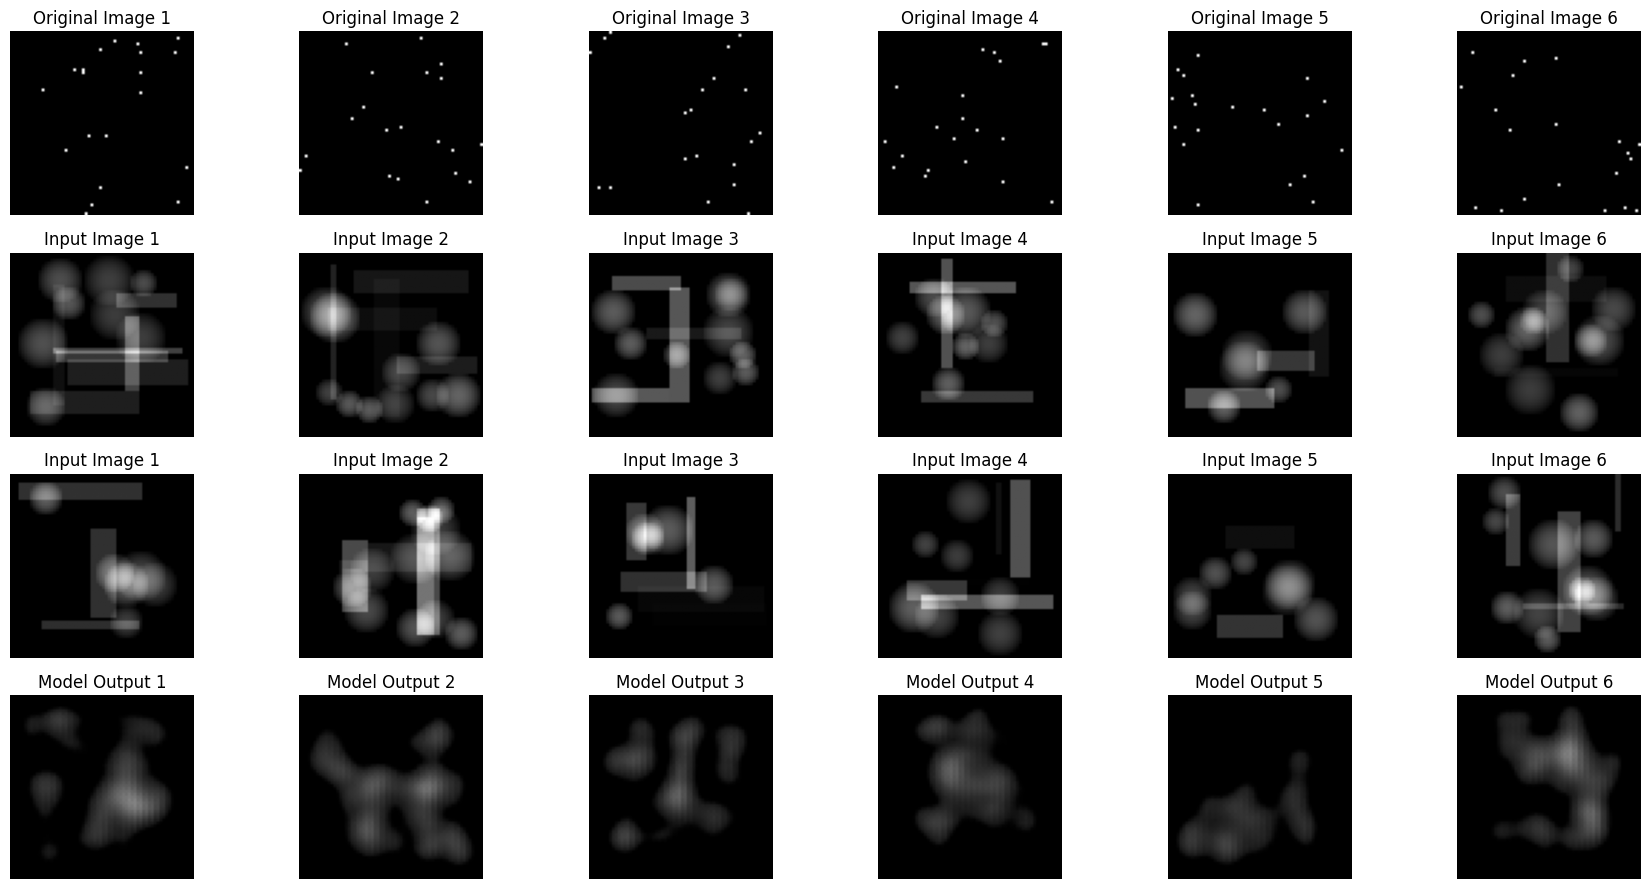

In [102]:
import matplotlib.pyplot as plt

# with torch.no_grad():
#     model.sensors_param.copy_(torch.flip(model.sensors_param, dims=[0]))


# model.eval()  # Set model to evaluation mode
batch_size = 6
images, _  = gen(batch_size)
with torch.no_grad():
  fake_images, _ = gen(batch_size)
  images = images.to(device)
  fake_images = fake_images.to(device)
  batched_shuffled_matrices = make_sensor_indices(batch_size,img_size=64,device=device).unsqueeze(1)
  # Construction des inputs & targets
  # inputs = noise_coeff * torch.rand(images.shape, device=device) # + F.relu(0.1 * torch.randn(images.shape))
  inputs = images.flatten()[torch.randperm(images.numel())].reshape(images.shape)
  # inputs = torch.zeros(images.shape, device=device)
  inputs[(batched_shuffled_matrices < num_good_gauges) * (batched_shuffled_matrices >= num_known_good_gauges // 2)] = \
        images[(batched_shuffled_matrices < num_good_gauges) * (batched_shuffled_matrices >= num_known_good_gauges // 2)]
  inputs[batched_shuffled_matrices >= 64**2 - num_good_gauges] = fake_images[batched_shuffled_matrices  >= 64**2 - num_good_gauges]
  targets_mask = batched_shuffled_matrices < num_known_good_gauges // 2

# Get model predictions
with torch.no_grad():
    outputs, _ = model(inputs, batched_shuffled_matrices)  # Output shape: (batch_size, 1, 64, 64)

loss = loss_masked_mae(outputs, images, targets_mask) + (torch.relu(sensor_params - 3) + torch.relu(-3 - sensor_params)).mean()
print(f'loss {loss:.4f}')
print(f'mean MAE : {torch.mean(torch.abs(outputs - images)):.4f}')
# Move data to CPU for visualization
images = images.cpu().squeeze(1)  # Shape: (batch_size, 64, 64)
fake_images = fake_images.cpu().squeeze(1)  # Shape: (batch_size, 64, 64)
sensor_masks = (batched_shuffled_matrices.cpu() < 20).squeeze(1) # inputs[:,0].cpu()
# sensor_masks[0] = sensor_masks.mean(dim=0)
# sensor_masks[1] = ((batched_shuffled_matrices.cpu() < 20).squeeze(1))[0]
outputs = outputs.cpu().squeeze(1)  # Shape: (batch_size, 64, 64)

# Plot the images
fig, axes = plt.subplots(4, batch_size, figsize=(batch_size * 3, 9))

for i in range(batch_size):
    axes[0, i].imshow(sensor_masks[i], cmap="gray", vmin=0, vmax=1)
    axes[0, i].set_title(f"Original Image {i+1}")
    axes[0, i].axis("off")

    axes[1, i].imshow(images[i], cmap="gray", vmin=0, vmax=1)
    axes[1, i].set_title(f"Input Image {i+1}")
    axes[1, i].axis("off")

    axes[2, i].imshow(fake_images[i], cmap="gray", vmin=0, vmax=1)
    axes[2, i].set_title(f"Input Image {i+1}")
    axes[2, i].axis("off")

    axes[3, i].imshow(outputs[i], cmap="gray", vmin=0, vmax=1)
    axes[3, i].set_title(f"Model Output {i+1}")
    axes[3, i].axis("off")

plt.tight_layout()
plt.show()

print()


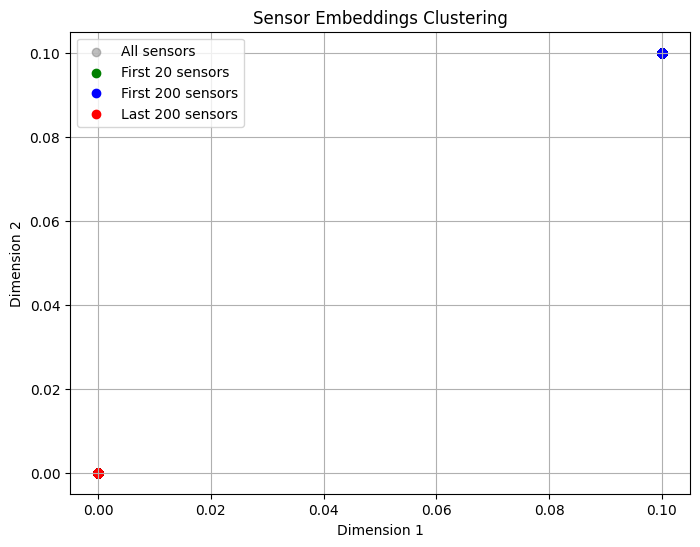

In [36]:
def plot_sensor_embeddings(model):
    """
    Plots the 2D sensor embeddings to check clustering of the first 200 vectors.

    Args:
        model (torch.nn.Module): The trained UNet model with `sensors_param` (4096x2).
    """
    # Extract sensor embeddings
    sensor_embeddings = model.sensors_param.cpu().detach().numpy()  # Shape: (4096, 2)

    # Scatterplot
    plt.figure(figsize=(8, 6))
    plt.scatter(sensor_embeddings[:, 0], sensor_embeddings[:, 1], alpha=0.5, label="All sensors", color="gray")
    plt.scatter(sensor_embeddings[:num_known_good_gauges, 0], sensor_embeddings[:num_known_good_gauges, 1], color="green", label="First 20 sensors")
    plt.scatter(sensor_embeddings[num_known_good_gauges:num_good_gauges, 0], sensor_embeddings[num_known_good_gauges:num_good_gauges, 1], color="blue", label="First 200 sensors")
    plt.scatter(sensor_embeddings[-num_good_gauges:, 0], sensor_embeddings[-num_good_gauges:, 1], color="red", label="Last 200 sensors")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.title("Sensor Embeddings Clustering")
    plt.legend()
    plt.grid()
    plt.show()

# Call after training
plot_sensor_embeddings(model)